In [1]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.model_selection import KFold,TimeSeriesSplit
import numpy as np
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.style.use('default') #ggplot스타일 사용

In [3]:
plt.style.use('ggplot') #ggplot스타일 사용
#한글폰트 사용
plt.rc('font', family='nanumgothic')
plt.rc('axes', unicode_minus=False)

In [4]:
plt.style.use('dark_background') #ggplot스타일 사용

---
# 데이터 Parsing
---

In [5]:
train = pd.read_csv('PJT002_train.csv')
test = pd.read_csv('PJT002_test.csv')
validation = pd.read_csv('PJT002_validation.csv')

C:\Users\tlsal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
'''불균형성이 크구나
그래서 평가척도 f1_score사용
class_weight는 balanced로 맞춤'''
train['fr_yn'].value_counts()

N    51542
Y     7657
Name: fr_yn, dtype: int64

In [6]:
'''object변수 인코딩 필요'''
train.dtypes.value_counts()

float64    147
object      13
int64       12
dtype: int64

In [8]:
len(train.columns)

172

In [26]:
train.columns

Index(['id', 'dt_of_fr', 'bldng_us', 'bldng_archtctr', 'bldng_cnt', 'bldng_ar',
       'ttl_ar', 'lnd_ar', 'dt_of_athrztn', 'ttl_grnd_flr',
       ...
       'mlt_us_yn', 'cctv_dstnc', 'cctv_in_100m', 'fr_wthr_fclt_in_100m',
       'tbc_rtl_str_dstnc', 'sft_emrgnc_bll_dstnc', 'ahsm_dstnc',
       'no_tbc_zn_dstnc', 'bldng_cnt_in_50m', 'fr_yn'],
      dtype='object', length=172)

---
# preprocessing
---

In [ ]:
'''date 컬럼으로 분해'''
'''frequency encoding 여부 고민'''
'''nan값 -999처리'''

In [33]:
train.isnull().sum()

id                          0
dt_of_fr                    0
bldng_us                27677
bldng_archtctr          27665
bldng_cnt                   0
                        ...  
sft_emrgnc_bll_dstnc        0
ahsm_dstnc                  0
no_tbc_zn_dstnc             0
bldng_cnt_in_50m            0
fr_yn                       0
Length: 172, dtype: int64

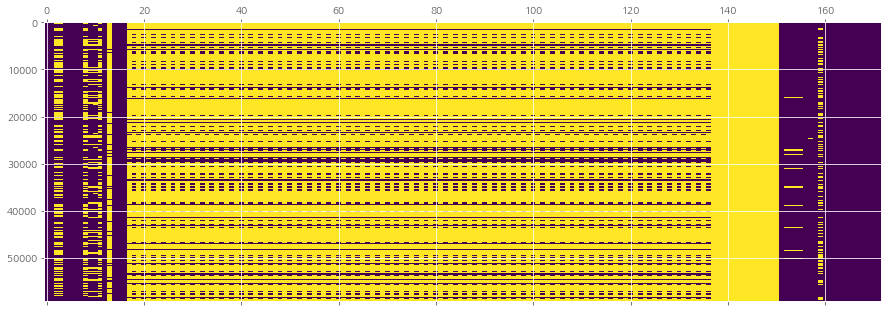

In [11]:
'''결측 데이터 확인 히트맵 - 결측치 패턴 탐색'''
df = train[train.columns.tolist()].isna().astype(int)

plt.figure(figsize=(15,5))
plt.matshow(df,fignum=1)
plt.gca().set_aspect('auto')

---
### 1. 연속형 변수 시각화
---

In [61]:
train.select_dtypes('float64').describe()

,bldng_ar,ttl_ar,lnd_ar,ttl_grnd_flr,ttl_dwn_flr,tmprtr,prcpttn,wnd_spd,wnd_drctn,hmdt,...,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011,hm_cnt,bldng_ar_prc,fr_mn_cnt
count,59199.000000,5.919900e+04,5.919900e+04,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,...,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,5.919900e+04,59199.000000
mean,633.562740,2.477958e+03,2.900026e+04,-169.654234,-185.604672,13.793176,-904.842621,0.977658,155.424619,65.451832,...,-994.250196,-994.391166,-994.391236,-993.990265,-993.990265,-994.059066,-994.075635,10780.382388,4.027723e+05,150.422693
std,9211.774472,7.831936e+04,2.157306e+06,378.909692,388.691508,17.917744,292.168971,23.652092,144.043126,31.204936,...,68.778215,67.712227,67.711196,70.671057,70.671057,70.178695,70.064014,12846.700673,4.993606e+05,47.605273
min,0.000000,0.000000e+00,0.000000e+00,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-9.990000e+02,-999.000000
25%,46.280000,5.055000e+01,0.000000e+00,1.000000,0.000000,6.100000,-999.000000,0.600000,20.000000,48.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,2816.000000,-9.990000e+02,112.000000
50%,87.730000,9.720000e+01,1.600000e+02,1.000000,0.000000,14.700000,-999.000000,1.200000,160.000000,68.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,5709.000000,2.369620e+05,161.000000
75%,155.100000,2.144150e+02,4.460000e+02,2.000000,0.000000,22.000000,-999.000000,2.200000,270.000000,87.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,13440.000000,6.753230e+05,176.000000
max,572897.955000,1.235184e+07,2.038984e+08,594.000000,60.000000,38.100000,93.000000,15.300000,360.000000,100.000000,...,5.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,115081.000000,1.568930e+07,210.000000


In [67]:
train.loc[:,variable_df[variable_df['na_per']<=50]['column'].tolist()].describe()

C:\Users\tlsal\Anaconda3\lib\site-packages\pandas\core\indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,id,dt_of_fr,bldng_us,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,dt_of_athrztn,ttl_grnd_flr,...,mlt_us_yn,cctv_dstnc,cctv_in_100m,fr_wthr_fclt_in_100m,tbc_rtl_str_dstnc,sft_emrgnc_bll_dstnc,ahsm_dstnc,no_tbc_zn_dstnc,bldng_cnt_in_50m,fr_yn
count,59199.000000,0.0,59199.000000,59199.000000,59199.000000,59199.000000,5.919900e+04,5.919900e+04,59199.000000,59199.000000,...,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000,59199.000000
mean,103558.889947,NaN,7.268282,5.358080,3.453927,633.562740,2.477958e+03,2.900026e+04,7830.123161,-169.654234,...,0.003193,760.094917,0.415480,0.246119,3253.293383,31396.045626,8974.286964,1146.474636,3.815200,0.129343
std,19921.311548,NaN,9.095286,5.873438,7.220839,9211.774472,7.831936e+04,2.157306e+06,4058.861046,378.909692,...,0.056413,1337.103386,1.176513,0.608620,3329.985798,24248.943785,11377.904356,1671.199571,8.410348,0.335582
min,69056.000000,NaN,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-999.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,86303.500000,NaN,0.000000,0.000000,1.000000,46.280000,5.055000e+01,0.000000e+00,4523.000000,1.000000,...,0.000000,100.000000,0.000000,0.000000,527.000000,11229.000000,761.000000,115.000000,0.000000,0.000000
50%,103561.000000,NaN,3.000000,2.000000,2.000000,87.730000,9.720000e+01,1.600000e+02,10173.000000,1.000000,...,0.000000,288.000000,0.000000,0.000000,2184.000000,27037.000000,3210.000000,422.000000,0.000000,0.000000
75%,120781.500000,NaN,10.000000,11.000000,4.000000,155.100000,2.144150e+02,4.460000e+02,11231.000000,2.000000,...,0.000000,889.000000,0.000000,0.000000,4958.000000,45713.000000,14239.500000,1486.500000,3.000000,0.000000
max,138108.000000,NaN,34.000000,18.000000,705.000000,572897.955000,1.235184e+07,2.038984e+08,11231.000000,594.000000,...,1.000000,12278.000000,24.000000,10.000000,23228.000000,103571.000000,56485.000000,16164.000000,84.000000,1.000000


In [6]:
train['fr_wthr_fclt_dstnc'] = train['fr_wthr_fclt_dstnc'].astype('float64')

In [7]:
'''커널밀도함수 - 연속형변수 시각화'''
def kde_target(df,variable):

    avg_yes_fr = df.ix[df['fr_yn']=='Y',variable].median()
    avg_no_fr = df.ix[df['fr_yn']=='N',variable].median()
    
    plt.figure(figsize=(12,8))
    
    sns.kdeplot(df.ix[df['fr_yn']=='Y',variable],label = 'TARGET == Y')
    sns.kdeplot(df.ix[df['fr_yn']=='N',variable],label = 'TARGET == N')
    
    plt.xlabel(variable); plt.ylabel('Density'); plt.title('%s Distribution' % variable)
    plt.legend();
    plt.show()
    
    print('Median value for loan that was yes_fire = %0.4f' % avg_yes_fr)
    print('Median value for loan that was no_fire =     %0.4f' % avg_no_fr)


C:\Users\tlsal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\tlsal\Anaconda3\lib\site-packages\pandas\core\indexing.py:947: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
C:\Users\tlsal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
C:\U

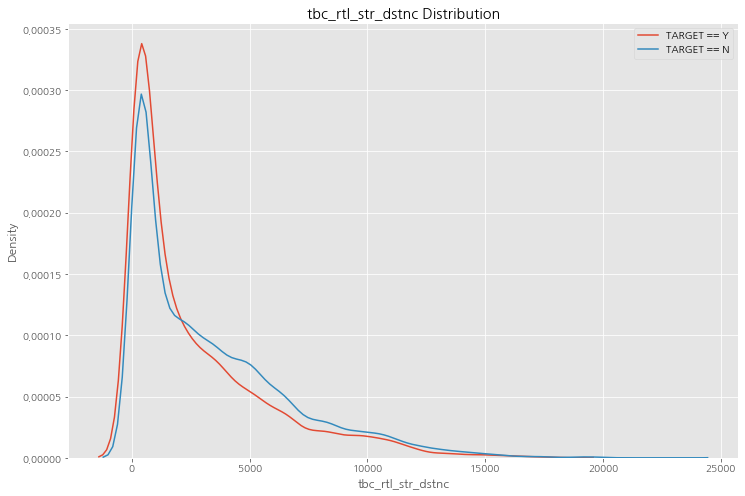

Median value for loan that was not repaid = 1395.0000
Median value for loan that was repaid =     2307.0000


In [28]:
kde_target(train,'tbc_rtl_str_dstnc')

In [40]:
train.select_dtypes('object').columns

Index(['bldng_us', 'bldng_archtctr', 'dt_of_athrztn', 'bldng_us_clssfctn',
       'jmk', 'rgnl_ar_nm', 'rgnl_ar_nm2', 'lnd_us_sttn_nm', 'rd_sd_nm',
       'emd_nm', 'mlt_us_yn', 'fr_yn'],
      dtype='object')

In [8]:
big,middle,small = [],[],[]
for i in range(len(train)):
    try:
        area_split = train['emd_nm'].iloc[i].split(' ')
        big.append(area_split[0])
        middle.append(area_split[1])
        small.append(area_split[2])
    except:
        big.append(np.nan)
        middle.append(np.nan)
        small.append(np.nan)
        pass

In [9]:
train['big'] = big
train['middle'] = middle
train['small'] = small

In [10]:
'''categorical데이터'''
a = train.select_dtypes('object')
cate = pd.DataFrame()
for i in range(len(a.columns)):
    a0 = a.iloc[:,i].value_counts(dropna=True).keys().tolist()
    
    cate0 = pd.DataFrame({'var_nm':[a.columns[i]],
                        'cate_data':[a0],
                        'cate_num':[len(a0)]})
    
    cate = cate.append(cate0)
    cate.index = range(len(cate))

In [81]:
pd.merge(cate,variable_df,left_on='var_nm',right_on='column',how='left').drop(columns='column')

,var_nm,cate_data,cate_num,Na,na_per
0,dt_of_fr,"[2014-10-25 19:44:36, 2018-12-27 16:02:52, 201...",59169,0.0,0.00
1,bldng_us,"[단독주택, 제1종근린생활시설, 제2종근린생활시설, 창고시설, 동.식물 관련시설, ...",34,27677.0,46.75
2,bldng_archtctr,"[벽돌구조, 일반목구조, 철근콘크리트구조, 블록구조, 경량철골구조, 일반철골구조, ...",18,27665.0,46.73
3,dt_of_athrztn,"[1945.0, 1935.0, 1940.0, 1950.0, 1955.0, 1960....",12054,27581.0,46.59
4,bldng_us_clssfctn,"[주거용, 상업용, 기타, 농수산용, 공업용, 문교사회용, 공공용]",7,29343.0,49.57
5,jmk,"[대, 전, 답, 장, 잡, 창, 임, 목, 도, 종, 학, 구, 과, 천, 주, ...",26,0.0,0.00
6,rgnl_ar_nm,"[계획관리지역, 제2종일반주거지역, 제1종일반주거지역, 자연녹지지역, 일반상업지역,...",23,1491.0,2.52
7,rgnl_ar_nm2,"[지정되지않음, 자연녹지지역, 제2종일반주거지역, 계획관리지역, 보전관리지역, 제1...",19,1491.0,2.52
8,lnd_us_sttn_nm,"[단독, 주거기타, 상업용, 주상용, 공업용, 전, 답, 주거나지, 답기타, 전기타...",44,1776.0,3.00
9,rd_sd_nm,"[세로한면(가), 세로한면(불), 소로한면, 맹지, 소로각지, 중로한면, 세로각지(...",13,1491.0,2.52


---
### 2. 카테고리 변수 시각화
---

In [11]:
'''시각화할 변수 정의'''
visual_cate_df = cate[cate['cate_num']<=45].iloc[[0,1,2,3,4,5,6,7,8,11],:]

In [12]:
'''각 categorical 변수별로 데이터의 수를 확인한 다음 
화재가 발생하지 않는 값에 대한 화재가 발생할 비율을 구해서 각각 비교해준다'''
cate_ratio = pd.DataFrame()
for i in range(len(visual_cate_df)):
    cate_ls = visual_cate_df['cate_data'].iloc[i]
    
    yes_fire_rate = []
    ls_nm = []
    col_nm = []
    count_nm = []
    for j in range(len(cate_ls)):
        target = train[train[visual_cate_df['var_nm'].iloc[i]]==cate_ls[j]]
        
        ls_nm.append(cate_ls[j])
        col_nm.append(visual_cate_df['var_nm'].iloc[i])
        try:
            yes_fire_rate.append(len(target[target['fr_yn']=='Y'])/len(target[target['fr_yn']=='N']))
        except:
            yes_fire_rate.append(0)
            
        count_nm.append(len(target))
    
    cate_ratio0 = pd.DataFrame()
    cate_ratio0['col_nm'] = col_nm
    cate_ratio0['ls_nm'] = ls_nm
    cate_ratio0['yes_fire_rate'] = yes_fire_rate
    cate_ratio0['count_value'] = count_nm
    
    cate_ratio = cate_ratio.append(cate_ratio0)

In [13]:
cate_ratio

,col_nm,ls_nm,yes_fire_rate,count_value
0,bldng_us,단독주택,0.210844,20232
1,bldng_us,제1종근린생활시설,0.451513,2350
2,bldng_us,제2종근린생활시설,0.523232,2262
3,bldng_us,창고시설,0.263993,1513
4,bldng_us,동.식물 관련시설,0.334850,1467
5,bldng_us,공장,1.237192,1179
6,bldng_us,공동주택,1.628492,941
7,bldng_us,숙박시설,0.746667,262
8,bldng_us,노유자시설,0.331169,205
9,bldng_us,교육연구시설,1.032967,185


In [14]:
def visual_code2(variable):
    global cate_ratio
    data = cate_ratio
    col_df = data[data['col_nm']==variable]
    
    col_df = col_df.sort_values('yes_fire_rate',ascending=False)
    
    label = col_df['ls_nm'].tolist()
    x = np.arange(len(label))

    yes_fire_rate = col_df['yes_fire_rate'].tolist()
    
    count_value = col_df['count_value'].tolist()

    plt.figure(figsize=(12,8))
    plt.bar(x,yes_fire_rate,color = 'rgbkymc')
    plt.xticks(x,label,rotation=90,fontsize=12)
    plt.ylim(0,yes_fire_rate[0]+0.1)
    plt.title(variable+'변수의 화재 발생 비율')
    plt.xlabel(variable)
    plt.ylabel('비율')
    
    for i,v in enumerate(count_value):
        plt.text(i-0.4,yes_fire_rate[i]+0.01,str(v),color='white',fontweight='bold',size=15)
    plt.show()
    print(col_df[col_df['count_value']==col_df['count_value'].max()]['ls_nm'].iloc[0]+'범주가 빈도수는 가장 높지만\n\n'+'범주중에 '+col_df[col_df['yes_fire_rate']==col_df['yes_fire_rate'].max()]['ls_nm'].iloc[0]+
     ' 범주가 화재 발생 비율이 더 높습니다.')

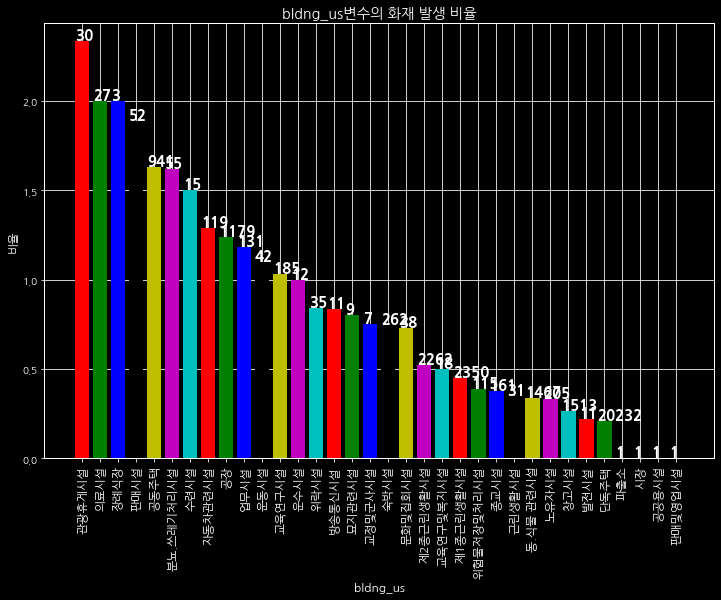

단독주택범주가 빈도수는 가장 높지만

범주중에 관광휴게시설 범주가 화재 발생 비율이 더 높습니다.


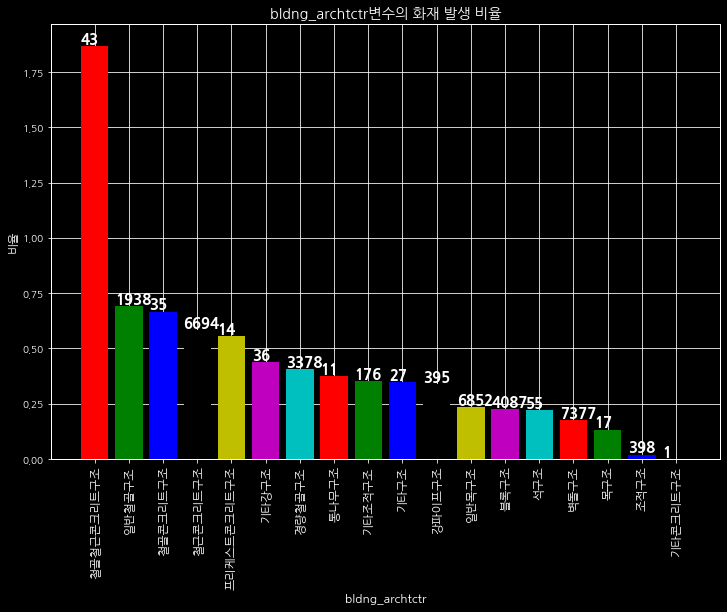

벽돌구조범주가 빈도수는 가장 높지만

범주중에 철골철근콘크리트구조 범주가 화재 발생 비율이 더 높습니다.


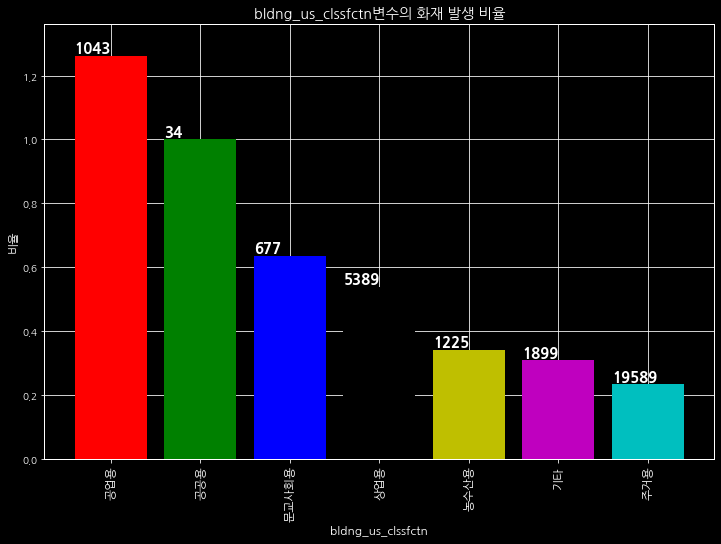

주거용범주가 빈도수는 가장 높지만

범주중에 공업용 범주가 화재 발생 비율이 더 높습니다.


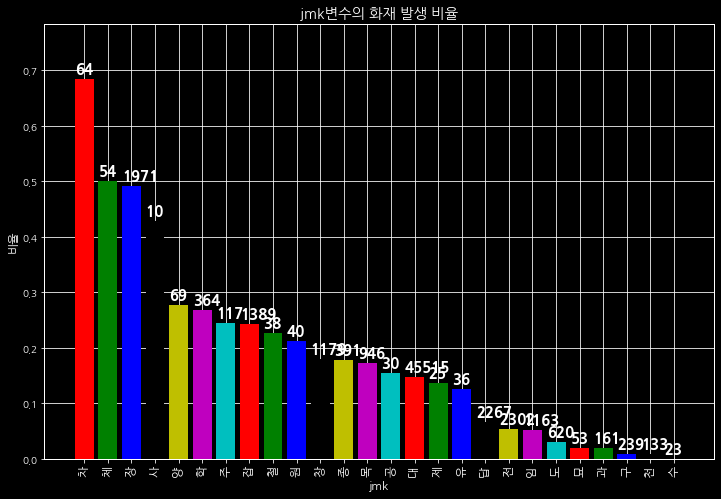

대범주가 빈도수는 가장 높지만

범주중에 차 범주가 화재 발생 비율이 더 높습니다.


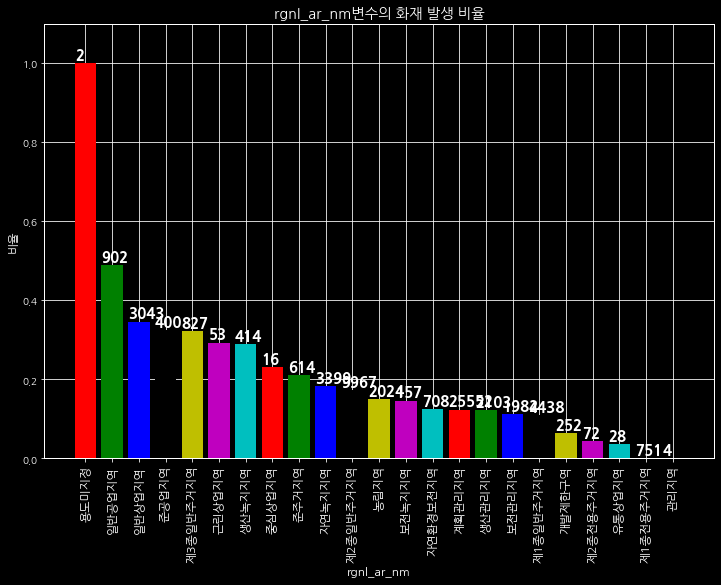

계획관리지역범주가 빈도수는 가장 높지만

범주중에 용도미지정 범주가 화재 발생 비율이 더 높습니다.


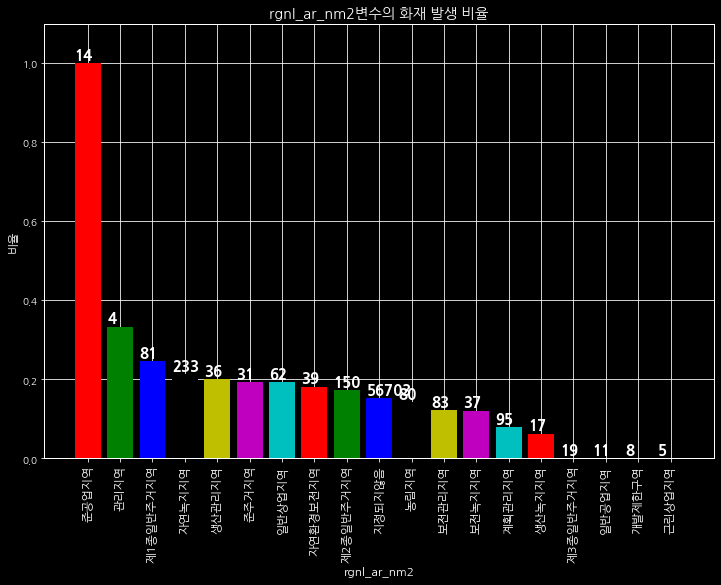

지정되지않음범주가 빈도수는 가장 높지만

범주중에 준공업지역 범주가 화재 발생 비율이 더 높습니다.


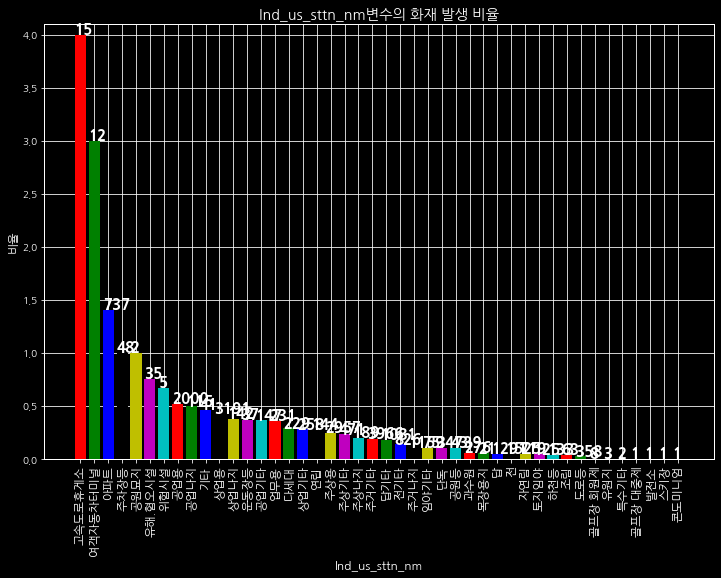

단독범주가 빈도수는 가장 높지만

범주중에 고속도로휴게소 범주가 화재 발생 비율이 더 높습니다.


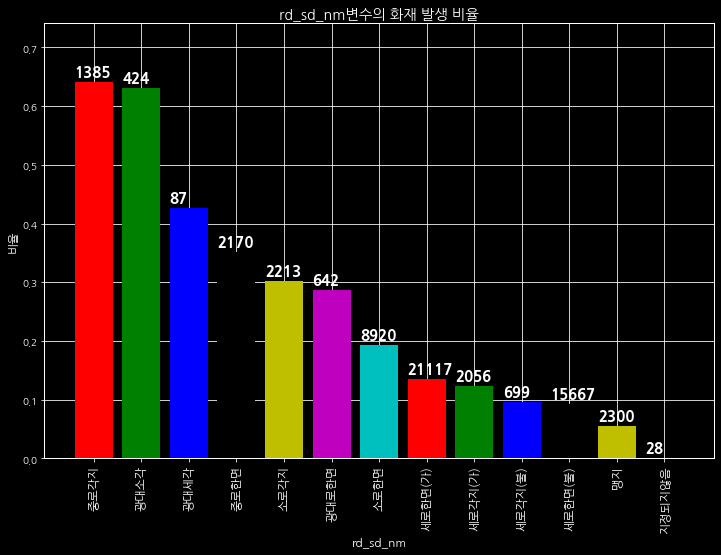

세로한면(가)범주가 빈도수는 가장 높지만

범주중에 중로각지 범주가 화재 발생 비율이 더 높습니다.


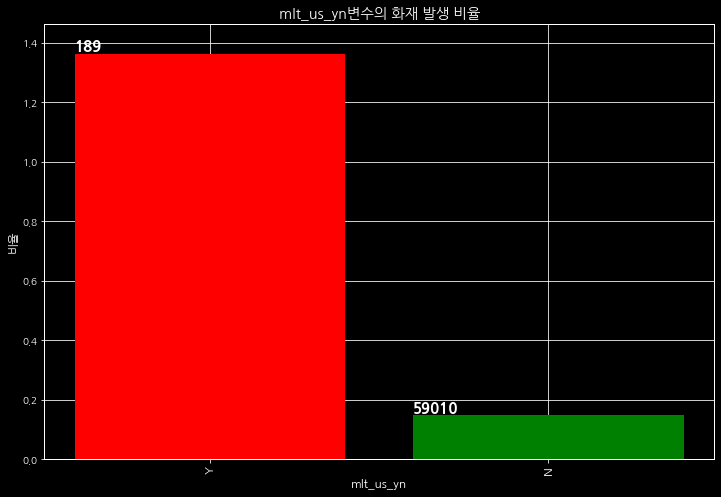

N범주가 빈도수는 가장 높지만

범주중에 Y 범주가 화재 발생 비율이 더 높습니다.


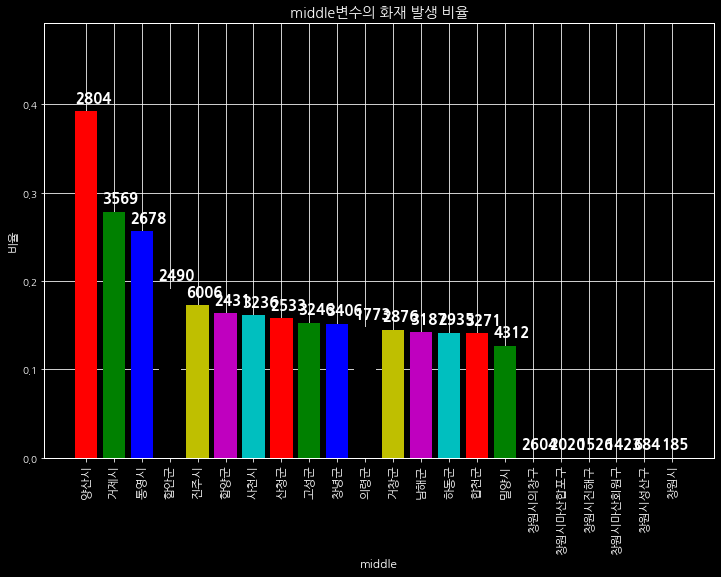

진주시범주가 빈도수는 가장 높지만

범주중에 양산시 범주가 화재 발생 비율이 더 높습니다.


In [121]:
'''해당 범주의 빈도 개수가 일정 개수 이하인 것들은 제거하고 다시 시각화하면 좋을 듯'''

visual_cate_ls = visual_cate_df['var_nm'].tolist()

for i in visual_cate_ls:
    visual_code2(i)

In [ ]:
'''연속형 데이터셋'''


In [17]:
'''정수형 데이터 셋'''
b = train.select_dtypes('int64')
inte = pd.DataFrame()
for i in range(len(b.columns)):
    b0 = b.iloc[:,i].value_counts(dropna=False).keys().tolist()
    
    inte0 = pd.DataFrame({'var_nm':[b.columns[i]],
                        'inte_data':[b0],
                        'inte_num':[len(b0)]})
    
    inte = inte.append(inte0)
    inte.index = range(len(inte))

In [51]:
inte

,var_nm,inte_data,inte_num
0,id,"[135166, 115373, 129706, 123561, 125608, 10307...",59199
1,bldng_cnt,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...",96
2,fr_sttn_dstnc,"[1120, 1338, 1312, 927, 1671, 912, 1435, 1085,...",15955
3,fr_wthr_fclt_dstnc,"[62, 46, 61, 48, 72, 51, 57, 89, 59, 45, 42, 7...",9090
4,cctv_dstnc,"[58, 79, 57, 69, 64, 73, 70, 84, 77, 42, 46, 8...",4879
5,cctv_in_100m,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 12,...",23
6,fr_wthr_fclt_in_100m,"[0, 1, 2, 3, 4, 5, 6, 7, 10, 8]",10
7,tbc_rtl_str_dstnc,"[0, 188, 228, 301, 165, 224, 326, 268, 278, 31...",11574
8,sft_emrgnc_bll_dstnc,"[414, 365, 231, 307, 803, 322, 37706, 258, 376...",38878
9,ahsm_dstnc,"[291, 306, 351, 251, 391, 377, 236, 205, 335, ...",21892


In [18]:
'''정수형 변수로도 원하는 변수로 동일한 시각화를 통해 결과 도출'''
'''+ 커널밀도함수도 같이 시각화해보자'''
'''사용할 정수형 변수 컬럼'''
visual_inte_df = inte[inte['inte_num']<=75]

In [21]:
'''각 categorical 변수별로 데이터의 수를 확인한 다음 
화재가 발생하지 않는 값에 대한 화재가 발생할 비율을 구해서 각각 비교해준다'''

inte_ratio = pd.DataFrame()
for i in range(len(visual_inte_df)):
    inte_ls = visual_inte_df['inte_data'].iloc[i]
    
    yes_fire_rate = []
    ls_nm = []
    col_nm = []
    count_nm = []
    for j in range(len(inte_ls)):
        target = train[train[visual_inte_df['var_nm'].iloc[i]]==inte_ls[j]]
        
        ls_nm.append(inte_ls[j])
        col_nm.append(visual_inte_df['var_nm'].iloc[i])
        try:
            yes_fire_rate.append(len(target[target['fr_yn']=='Y'])/len(target[target['fr_yn']=='N']))
        except:
            yes_fire_rate.append(0)
            
        count_nm.append(len(target))
    
    inte_ratio0 = pd.DataFrame()
    inte_ratio0['col_nm'] = col_nm
    inte_ratio0['ls_nm'] = ls_nm
    inte_ratio0['yes_fire_rate'] = yes_fire_rate
    inte_ratio0['count_value'] = count_nm
    
    inte_ratio = inte_ratio.append(inte_ratio0)

In [27]:
inte_ratio

,col_nm,ls_nm,yes_fire_rate,count_value
0,cctv_in_100m,0,0.142190,47659
1,cctv_in_100m,1,0.177180,5860
2,cctv_in_100m,2,0.181075,2746
3,cctv_in_100m,3,0.157356,1243
4,cctv_in_100m,4,0.172819,699
5,cctv_in_100m,5,0.140957,429
6,cctv_in_100m,6,0.100000,187
7,cctv_in_100m,7,0.206897,140
8,cctv_in_100m,8,0.150000,92
9,cctv_in_100m,9,0.384615,36


In [33]:
'''현재는 시각화를 두개의 평면에 따로 그리지만 두개의 그래프를 하나로 합치는 작업을 함'''
def visual_code2(variable):
    global inte_ratio
    data = inte_ratio
    col_df = data[data['col_nm']==variable]
    
    col_df = col_df.sort_values('yes_fire_rate',ascending=False)
    
    label = col_df['ls_nm'].tolist()
    x = np.arange(len(label))

    yes_fire_rate = col_df['yes_fire_rate'].tolist()
    
    count_value = col_df['count_value'].tolist()

    plt.figure(figsize=(12,8))
    plt.bar(x,yes_fire_rate,color = 'rgbkymc')
    plt.xticks(x,label,rotation=90,fontsize=12)
    plt.ylim(0,yes_fire_rate[0]+0.1)
    plt.title(variable+'변수의 화재 발생 비율')
    plt.xlabel(variable)
    plt.ylabel('비율')
    
    for i,v in enumerate(count_value):
        plt.text(i-0.4,yes_fire_rate[i]+0.01,str(v),color='white',fontweight='bold',size=15)
    plt.show()
    #print(col_df[col_df['count_value']==col_df['count_value'].max()]['ls_nm'].iloc[0]+'범주가 빈도수는 가장 높지만\n\n'+'범주중에 '+col_df[col_df['yes_fire_rate']==col_df['yes_fire_rate'].max()]['ls_nm'].iloc[0]+
    # ' 범주가 화재 발생 비율이 더 높습니다.')

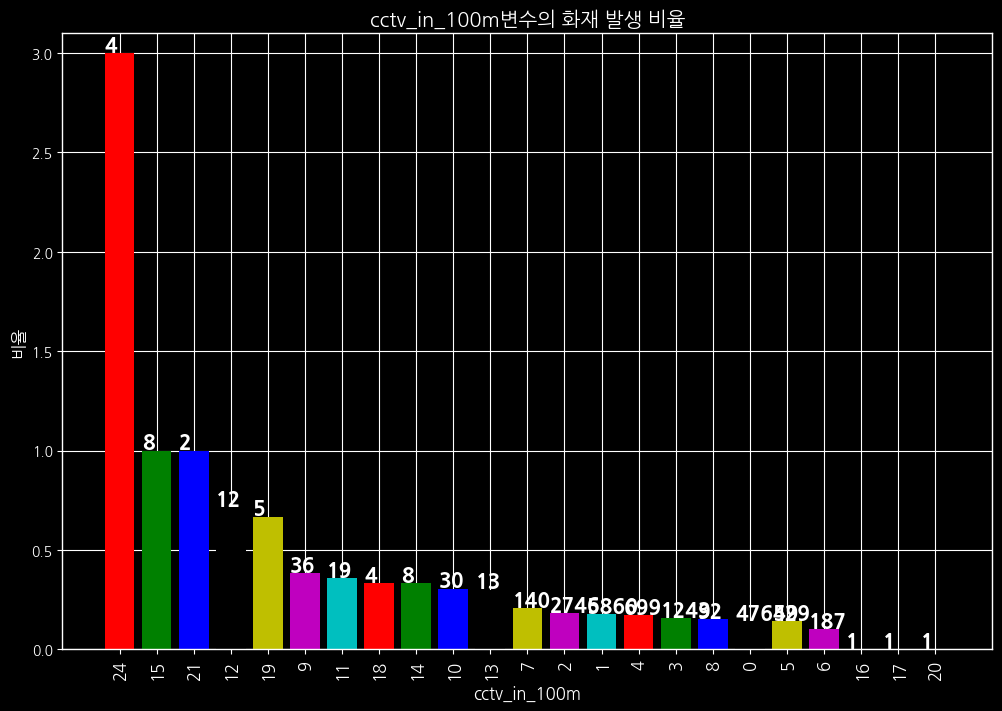

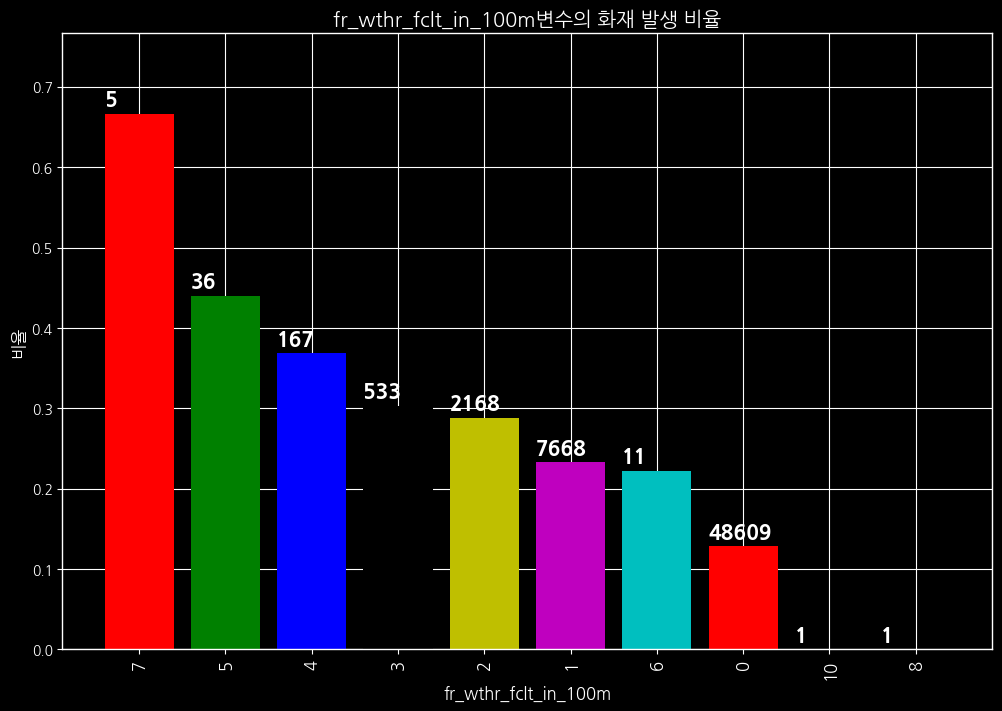

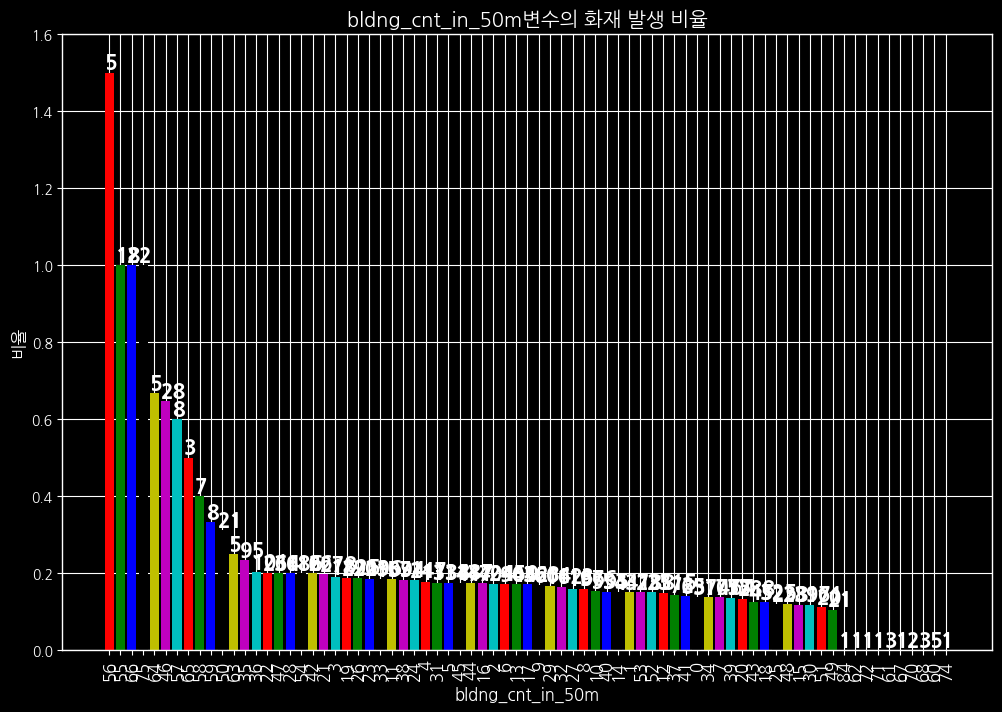

In [38]:
'''해당 범주의 빈도 개수가 일정 개수 이하인 것들은 제거하고 다시 시각화하면 좋을 듯'''
for i in visual_inte_df['var_nm'].tolist():
    visual_code2(i)

In [41]:
train['emd_nm']

0        경상남도 통영시 용남면
1        경상남도 통영시 용남면
2        경상남도 통영시 용남면
3        경상남도 통영시 용남면
4        경상남도 거창군 북상면
             ...     
59194    경상남도 통영시 용남면
59195    경상남도 통영시 용남면
59196    경상남도 통영시 용남면
59197    경상남도 통영시 용남면
59198    경상남도 통영시 용남면
Name: emd_nm, Length: 59199, dtype: object

---
# encoding
---
- label
- frequency

In [53]:
'''라벨인코딩하기 전에 date변수는 후에 계절변수로도 하나 만들고 시계열변수로도 하나 만들어도 좋을 듯'''
'''모델링할 때 잠깐 제외'''
train.drop(columns ='dt_of_fr',inplace=True)

'''label_encoding'''
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        
'''결측치 일단 -999로 치환 -> 결측치 예측하는 거 유찬이가 만들었을 때 판단'''
train.fillna(-999,inplace=True)

In [21]:
train['prcpttn'].value_counts()

0.0     2037
0.5      581
0.1      331
1.0      320
0.2      190
        ... 
33.0       1
7.1        1
25.5       1
22.5       1
11.8       1
Name: prcpttn, Length: 190, dtype: int64

In [7]:
'''결측치 데이터'''
variable_df = pd.DataFrame()
variable_df['column'] = train.isnull().sum().keys().tolist()
variable_df['Na'] = train.isnull().sum().values 

In [14]:
'''결측치 비율'''
variable_df['na_per'] = round(variable_df['Na']/len(train)*100,2)

In [66]:
variable_df[variable_df['na_per']<=50]['column'].tolist()

['id',
 'dt_of_fr',
 'bldng_us',
 'bldng_archtctr',
 'bldng_cnt',
 'bldng_ar',
 'ttl_ar',
 'lnd_ar',
 'dt_of_athrztn',
 'ttl_grnd_flr',
 'ttl_dwn_flr',
 'bldng_us_clssfctn',
 'tmprtr',
 'wnd_spd',
 'wnd_drctn',
 'hmdt',
 'jmk',
 'rgnl_ar_nm',
 'rgnl_ar_nm2',
 'lnd_us_sttn_nm',
 'rd_sd_nm',
 'emd_nm',
 'hm_cnt',
 'fr_sttn_dstnc',
 'bldng_ar_prc',
 'fr_wthr_fclt_dstnc',
 'fr_mn_cnt',
 'mlt_us_yn',
 'cctv_dstnc',
 'cctv_in_100m',
 'fr_wthr_fclt_in_100m',
 'tbc_rtl_str_dstnc',
 'sft_emrgnc_bll_dstnc',
 'ahsm_dstnc',
 'no_tbc_zn_dstnc',
 'bldng_cnt_in_50m',
 'fr_yn']

In [40]:
'''연면적에(>=3000) 따른 lw데이터들의 결측치 비율 비교'''
lw_ls = [i for i in train.columns.tolist() if 'lw' in i]

lw_df = pd.DataFrame()
for i in range(len(lw_ls)):
    up3000 = train[(train['ttl_ar']>=3000)][lw_ls[i]].value_counts(dropna=False).values[0]/train[lw_ls].isnull().sum()[i]
    down3000 = train[(train['ttl_ar']<3000)][lw_ls[i]].value_counts(dropna=False).values[0]/train[lw_ls].isnull().sum()[i]
    
    lw_df0 = pd.DataFrame({'lw_column':[lw_ls[i]],
                          'ttl_ar_up3000':[up3000],
                          'ttl_ar_down3000':[down3000]})
    
    lw_df = lw_df.append(lw_df0)
    
lw_df

,lw_column,ttl_ar_up3000,ttl_ar_down3000
0,lw_13101010,0.034739,0.965261
0,lw_13101110,0.034919,0.965081
0,lw_13101210,0.034821,0.965179
0,lw_13101211,0.034804,0.965196
0,lw_13101310,0.034885,0.965115
0,lw_13101410,0.035033,0.964967
0,lw_13111010,0.034771,0.965229
0,lw_13111110,0.035066,0.964934
0,lw_13121010,0.035197,0.964803
0,lw_13121011,0.035197,0.964803


---
# xgb baseline 모델링
---

In [55]:
data = train
variable = 'fr_yn'

In [57]:
data = data.sample(10000)

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=variable), 
                                                    np.array(data[variable].tolist()), 
                                                    test_size=0.2, 
                                                    stratify=np.array(data[variable].tolist()), 
                                                    random_state=123456)

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)
y_train = pd.Series(y_train)

columns = x_train.columns
splits = folds.split(x_train, y_train)
y_preds = np.zeros(x_test.shape[0])
y_oof = np.zeros(x_train.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [70]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    x_train2, x_valid = x_train[columns].iloc[train_index], x_train[columns].iloc[valid_index]
    y_train2, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    #dtrain = xgb.DMatrix(data=x_train2,label=y_train2)
    #dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
    
    #모델 생성(classification, regressor)
    xgb_class = xgb.XGBClassifier(n_estimators=100,random_state=0,max_depth=5,eval_metric='auc',class_weight='balanced')
    #모델 학습 (train,valid)
    xgb_class.fit(x_train2,y_train2)
    
    feature_importances[f'fold_{fold_n + 1}'] = xgb_class.feature_importances_
    y_pred_valid = xgb_class.predict(x_valid)
    y_oof[valid_index] = y_pred_valid
    
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    print('acc : ', accuracy_score())
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += xgb_class.predict(x_test) / NFOLDS
    #y_test와의 성능 비교는 auc를 평가척도로 놓았기 때문에 그대로 y_test와 auc로 성능을 검증하면 됨
    #근데 의문은 1/0으로 binary로 결과치가 도출되는데 왜 predict_proba로 예측을 하지 않지?
    
    #데이터 메모리를 최적화하면서 모델링 진행
    del x_train2, x_valid, y_train2, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")

Fold 1 | AUC: 0.6638074239066444
Fold 2 | AUC: 0.6242723252235481
Fold 3 | AUC: 0.6419725068084554
Fold 4 | AUC: 0.638132119824001
Fold 5 | AUC: 0.6437747035573124

Mean AUC = 0.6423918158639923
Out of folds AUC = 0.6423654688622744


In [63]:
xgb_class

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

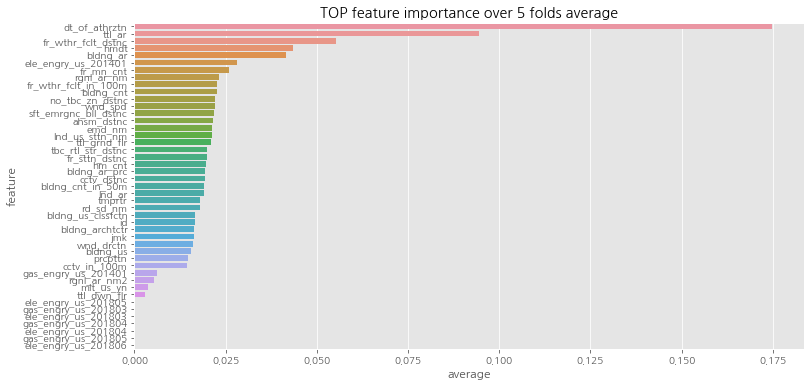

In [72]:
'''v2'''
#각 변수의 cross_validation별 평균 변수중요도
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(45), x='average', y='feature');
plt.title('TOP feature importance over {} folds average'.format(folds.n_splits));

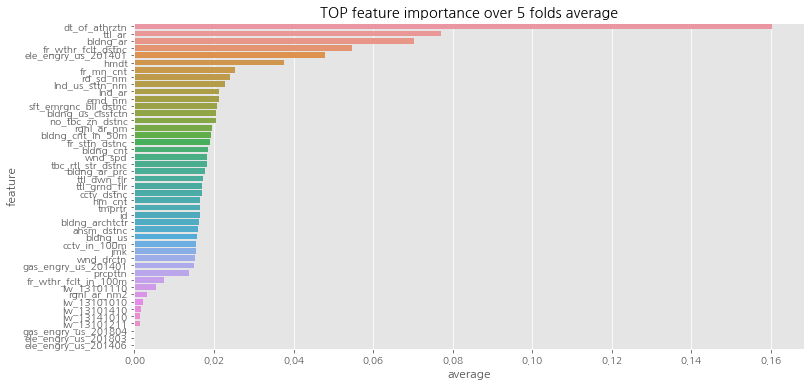

In [66]:
'''v2'''
#각 변수의 cross_validation별 평균 변수중요도
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(45), x='average', y='feature');
plt.title('TOP feature importance over {} folds average'.format(folds.n_splits));